In [1]:
# %pip install numpy
# %pip install pandas
# %pip install ipywidgets
# %pip install torch
# %pip install torchvision
# %pip install scikit-learn
# %pip install tensorflow
# %pip install pennylane
# %pip install opencv-python
# %pip install matplotlib
# %pip install seaborn
# %pip install kagglehub
# %pip install monai

In [33]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from monai.transforms import ScaleIntensity
import kagglehub
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, TensorDataset, WeightedRandomSampler
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import torchvision.transforms as transforms
import pennylane as qml
from pennylane import numpy as np

import warnings
warnings.filterwarnings("ignore")

Download latest version https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [3]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
# print("Path to dataset files:", path)

!!! Remove .DS_Store from folders

In [4]:
# !rm -rf {path}/chest_xray/chest_xray/train/NORMAL/.DS_Store
# !rm -rf {path}/chest_xray/chest_xray/train/PNEUMONIA/.DS_Store
# !rm -rf {path}/chest_xray/chest_xray/test/NORMAL/.DS_Store
# !rm -rf {path}/chest_xray/chest_xray/test/PNEUMONIA/.DS_Store

Define dataset paths

In [5]:
train_path_norm = os.path.join(path, "chest_xray", "train", "NORMAL")
train_path_pneu = os.path.join(path, "chest_xray", "train", "PNEUMONIA")
test_path_norm = os.path.join(path, "chest_xray", "test", "NORMAL")
test_path_pneu = os.path.join(path, "chest_xray", "test", "PNEUMONIA")

img_size = (224, 224)

Count files in directory

In [6]:
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.endswith(('.jpg', '.png', '.jpeg'))])

print("Length train_path_norm:", count_images(train_path_norm))
print("Length train_path_pneu:", count_images(train_path_pneu))
print("Length test_path_norm:", count_images(test_path_norm))
print("Length test_path_pneu:", count_images(test_path_pneu))

Length train_path_norm: 1341
Length train_path_pneu: 3875
Length test_path_norm: 234
Length test_path_pneu: 390


Check data

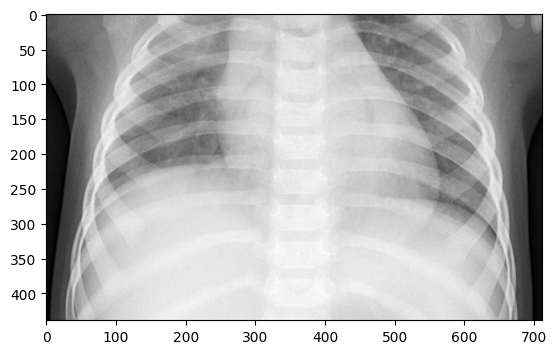

In [7]:
xray_image = cv2.imread(f'{train_path_pneu}/person1_bacteria_1.jpeg', cv2.IMREAD_GRAYSCALE)
plt.imshow(xray_image, cmap='gray')

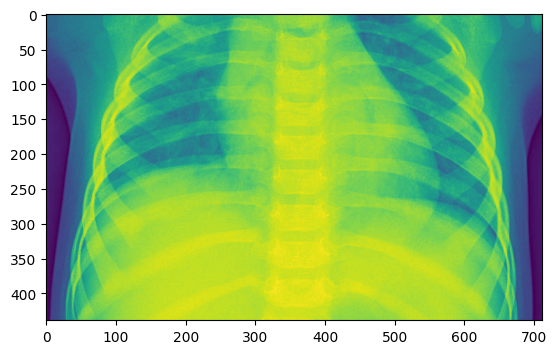

In [8]:
transform_img = ScaleIntensity(minv=0.0, maxv=1.0)
xray_image_scaled = transform_img(xray_image)
colored_xray = cm.viridis(xray_image_scaled)
plt.imshow(colored_xray)

Load and preprocess the images

In [9]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15)
])

def load_images_from_folder(folder, label, target_size=img_size):
    data, labels = [], []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path).convert("L").resize(target_size)
            data.append(np.array(img))
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
    return data, labels

def load_and_limit_data(path, label, num_samples, target_size=(224, 224)):
    data, labels = load_images_from_folder(path, label, target_size)
    indices = np.random.choice(len(data), min(num_samples, len(data)), replace=False)
    data = [data[i] for i in indices]
    labels = [labels[i] for i in indices]
    return data, labels

Display images for train

Found 5216 validated image filenames belonging to 2 classes.


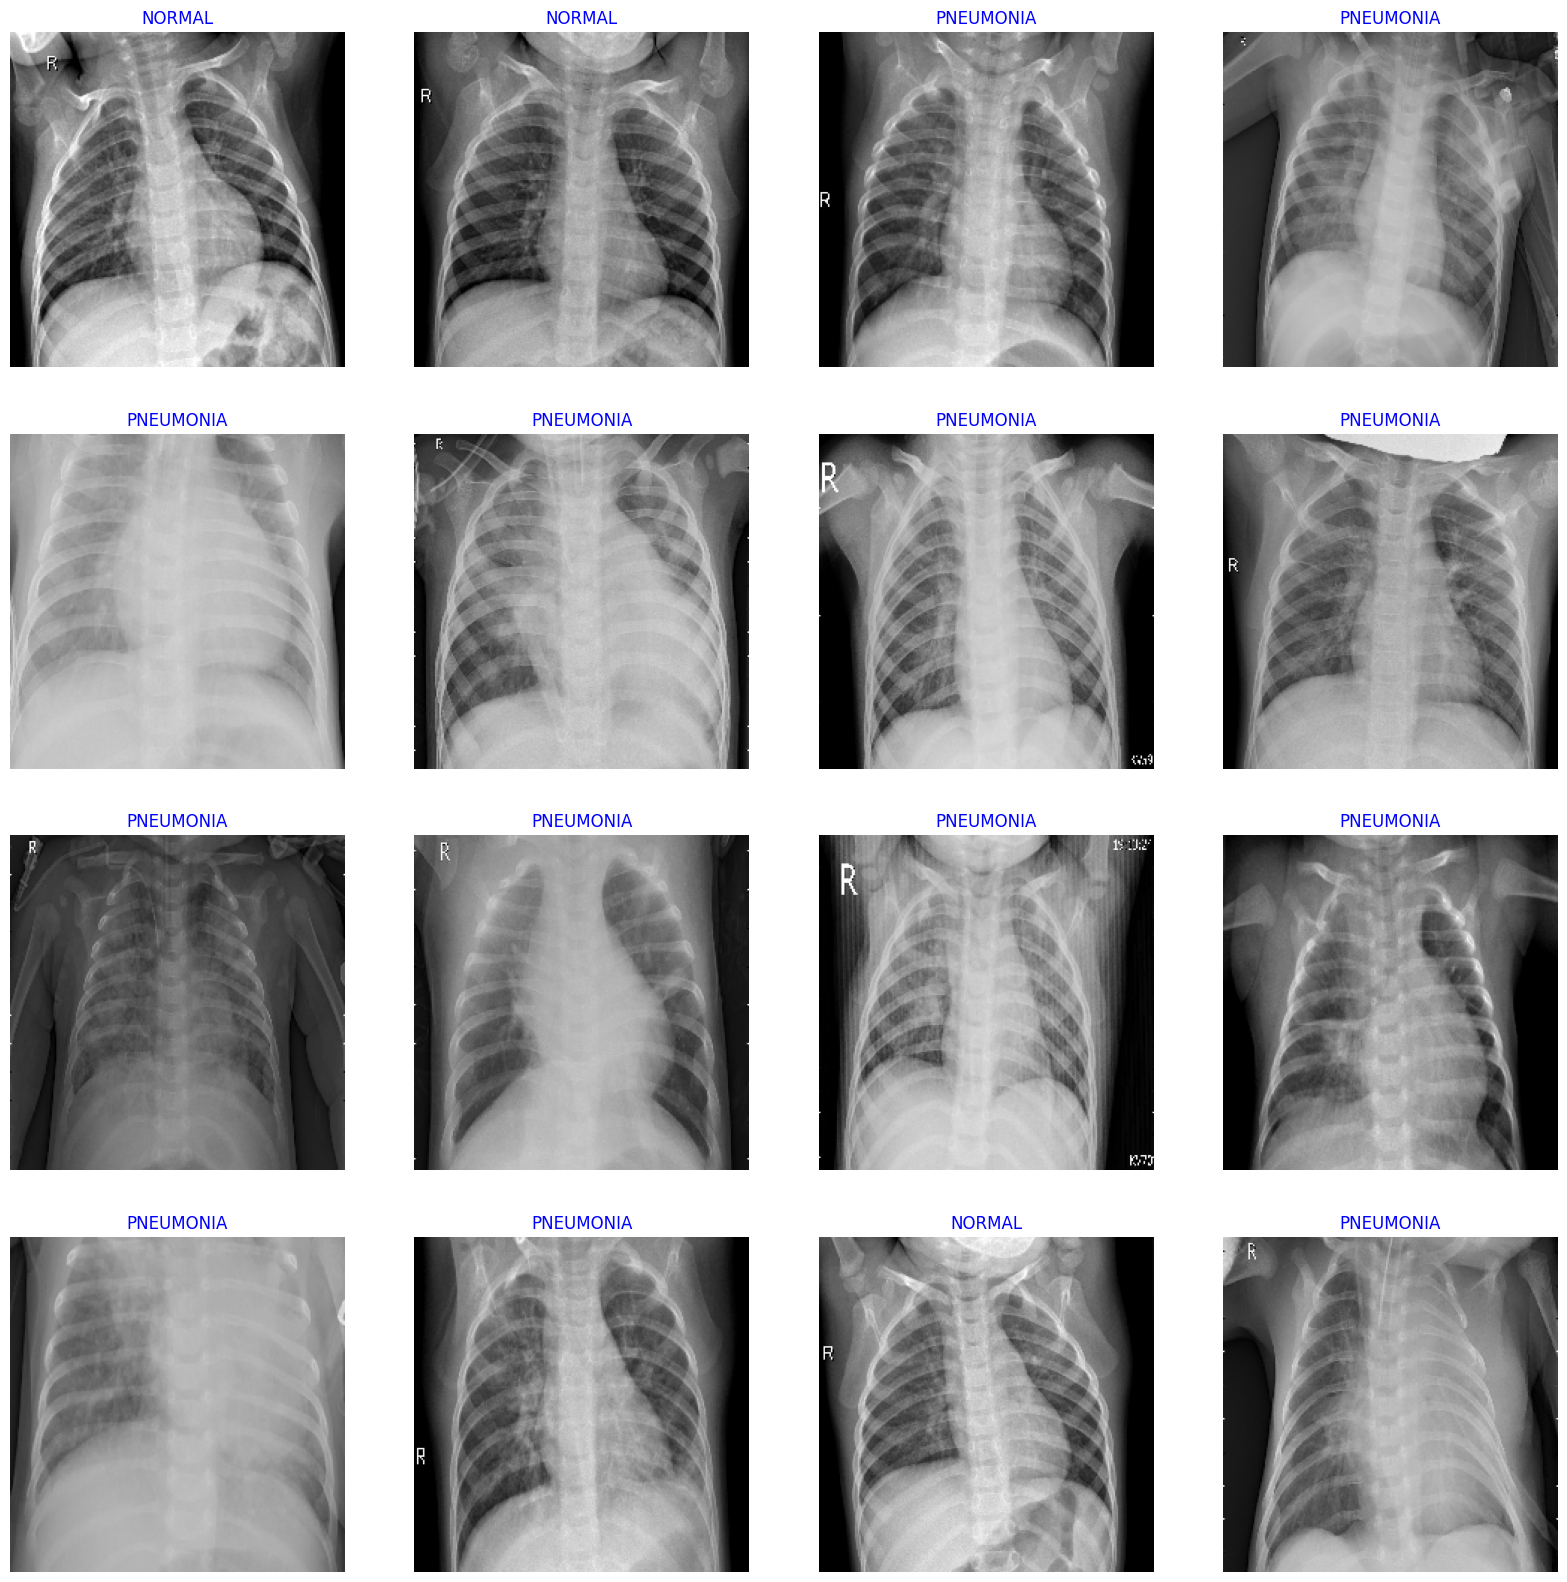

In [10]:
def create_dataframe_from_directory(directory, label):
    filepaths = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    labels = [label] * len(filepaths)
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

df_norm = create_dataframe_from_directory(train_path_norm, 'NORMAL')
df_pneu = create_dataframe_from_directory(train_path_pneu, 'PNEUMONIA')

train_df = pd.concat([df_norm, df_pneu], ignore_index=True)

train_df = train_df.sample(frac=1).reset_index(drop=True)

def scalar(img):
    return img

batch_size = 32
tr_gen = ImageDataGenerator(preprocessing_function= scalar)


train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col= 'filepaths',
    y_col= 'labels',
    target_size= img_size,
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle= True,
    batch_size= batch_size
)

g_dict = train_gen.class_indices     
classes = list(g_dict.keys())       
images, labels = next(train_gen)      
plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255     
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

Proportional sampling for balanced dataset

In [11]:
num_samples = 2000
num_samples_test = 500
norm_ratio = 1341 / (1341 + 3875)
pneu_ratio = 3875 / (1341 + 3875)
num_samples_norm = int(num_samples * norm_ratio)
num_samples_pneu = int(num_samples * pneu_ratio)
num_samples_norm_test = int(num_samples_test * norm_ratio)
num_samples_pneu_test = int(num_samples_test * pneu_ratio)

train_data_norm, train_labels_norm = load_and_limit_data(train_path_norm, 0, num_samples_norm)
train_data_pneu, train_labels_pneu = load_and_limit_data(train_path_pneu, 1, num_samples_pneu)
X_train = np.array(train_data_norm + train_data_pneu)
y_train = np.array(train_labels_norm + train_labels_pneu)

test_data_norm, test_labels_norm = load_and_limit_data(test_path_norm, 0, num_samples_norm_test)
test_data_pneu, test_labels_pneu = load_and_limit_data(test_path_pneu, 1, num_samples_pneu_test)
X_test = np.asarray(test_data_norm + test_data_pneu)
y_test = np.asarray(test_labels_norm + test_labels_pneu)

Convert to tensors

In [12]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Compute class weights for loss function
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Weighted sampler
class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
weights = 1. / class_sample_count
samples_weights = np.array([weights[t] for t in y_train])
sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Display the categorized file paths and labels

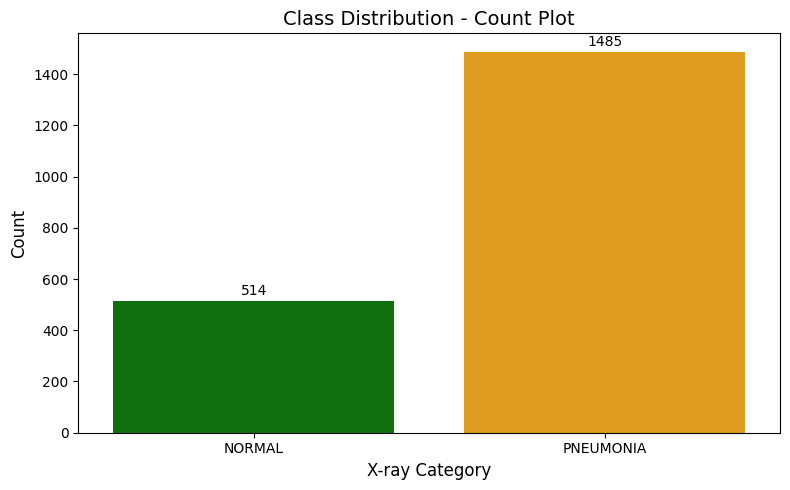

In [13]:
labels = train_labels_norm + train_labels_pneu

df = pd.DataFrame({'label': ['NORMAL' if lbl == 0 else 'PNEUMONIA' for lbl in labels]})

plt.figure(figsize=(8, 5))
ax = sns.countplot(
    data=df, 
    x='label', 
    hue='label',
    palette={'NORMAL': 'green', 'PNEUMONIA': 'orange'},
    dodge=False,
    legend=False
)

plt.title('Class Distribution - Count Plot', fontsize=14)
plt.xlabel('X-ray Category', fontsize=12)
plt.ylabel('Count', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 7.5), textcoords='offset points')

plt.tight_layout()
plt.show()

Set device to CPU

In [14]:
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


Set up PennyLane device

In [15]:
dev = qml.device("default.qubit", wires=4)

Define QSNN-like quantum circuit (hypothalamus stage)

In [16]:
@qml.qnode(dev, interface="torch")
def qsnn_circuit(inputs, weights):
    inputs = inputs.flatten()
    for i in range(4):
        qml.RX(np.pi * inputs[i], wires=i)
    qml.templates.StronglyEntanglingLayers(weights, wires=range(4))
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

qsnn_shapes = {"weights": (6, 4, 3)}
qsnn_layer = qml.qnn.TorchLayer(qsnn_circuit, qsnn_shapes).to(device)

Visualize QSNN circuit

Matplotlib is building the font cache; this may take a moment.


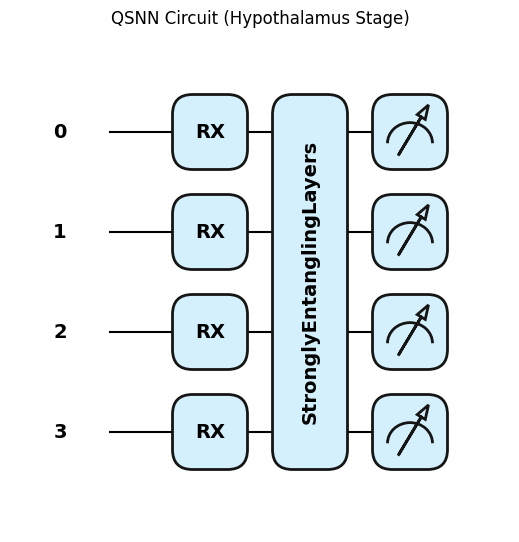

In [17]:
dummy_input = torch.tensor([0.1, 0.2, 0.3, 0.4], requires_grad=False)
dummy_weights = torch.rand(qsnn_shapes['weights'])
qml.draw_mpl(qsnn_circuit, style="pennylane")(dummy_input, dummy_weights)
plt.title("QSNN Circuit (Hypothalamus Stage)")
plt.show()

Define QLSTM-like circuit (hippocampus stage)

In [18]:
@qml.qnode(dev, interface="torch")
def qlstm_circuit(inputs, weights):
    inputs = inputs.flatten()
    for i in range(4):
        qml.RY(inputs[i], wires=i)
    qml.templates.StronglyEntanglingLayers(weights, wires=range(4))
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

qlstm_shapes = {"weights": (6, 4, 3)}
qlstm_layer = qml.qnn.TorchLayer(qlstm_circuit, qlstm_shapes).to(device)

Visualize QLSTM circuit

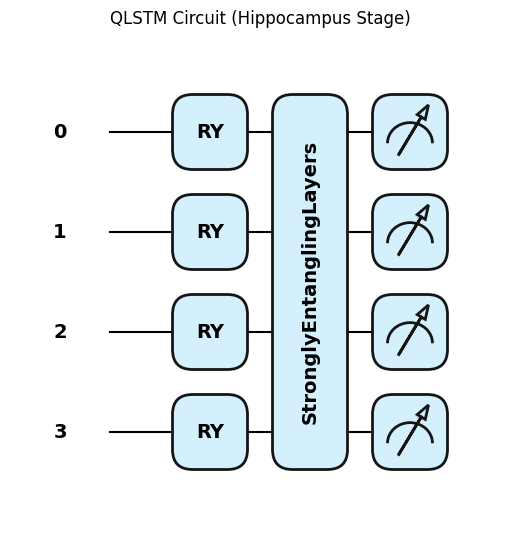

In [19]:
dummy_weights_qlstm = torch.rand(qlstm_shapes['weights'])
qml.draw_mpl(qlstm_circuit, style="pennylane")(dummy_input, dummy_weights_qlstm)
plt.title("QLSTM Circuit (Hippocampus Stage)")
plt.show()

Brain-Inspired Hybrid Model with QSNN + QLSTM

In [20]:
class BrainInspiredQuantumClassifier(nn.Module):
    def __init__(self):
        super(BrainInspiredQuantumClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((2, 2))
        self.fc1 = nn.Linear(64 * 2 * 2, 32)
        self.qsnn = qsnn_layer
        self.qlstm = qlstm_layer
        self.fc_post = nn.Linear(4, 32)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x_list = [self.qsnn(sample).to(device) for sample in x]
        x = torch.stack(x_list)
        x_list = [self.qlstm(sample).to(device) for sample in x]
        x = torch.stack(x_list)
        x = self.fc_post(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Training function

In [21]:
def fit_quantum_model(model, train_loader, epochs=50):
    model.train()
    history = {'loss': [], 'accuracy': []}
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
    criterion = nn.NLLLoss(weight=class_weights.to(device))

    for epoch in range(epochs):
        epoch_loss = 0
        correct = 0
        total = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        scheduler.step()
        avg_loss = epoch_loss / len(train_loader)
        accuracy = correct / total
        history['loss'].append(avg_loss)
        history['accuracy'].append(accuracy)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    return history

Training the model

In [22]:
quantum_model = BrainInspiredQuantumClassifier().to(device)

In [23]:
history = fit_quantum_model(quantum_model, train_loader, epochs=10)

Epoch [1/10], Loss: 0.6206, Accuracy: 0.5158
Epoch [2/10], Loss: 0.4043, Accuracy: 0.6738
Epoch [3/10], Loss: 0.2938, Accuracy: 0.8594
Epoch [4/10], Loss: 0.2443, Accuracy: 0.8909
Epoch [5/10], Loss: 0.2298, Accuracy: 0.8909
Epoch [6/10], Loss: 0.2172, Accuracy: 0.8909
Epoch [7/10], Loss: 0.2149, Accuracy: 0.8994
Epoch [8/10], Loss: 0.2213, Accuracy: 0.8869
Epoch [9/10], Loss: 0.1883, Accuracy: 0.9080
Epoch [10/10], Loss: 0.1944, Accuracy: 0.9060


#### Plotting accuracy and loss

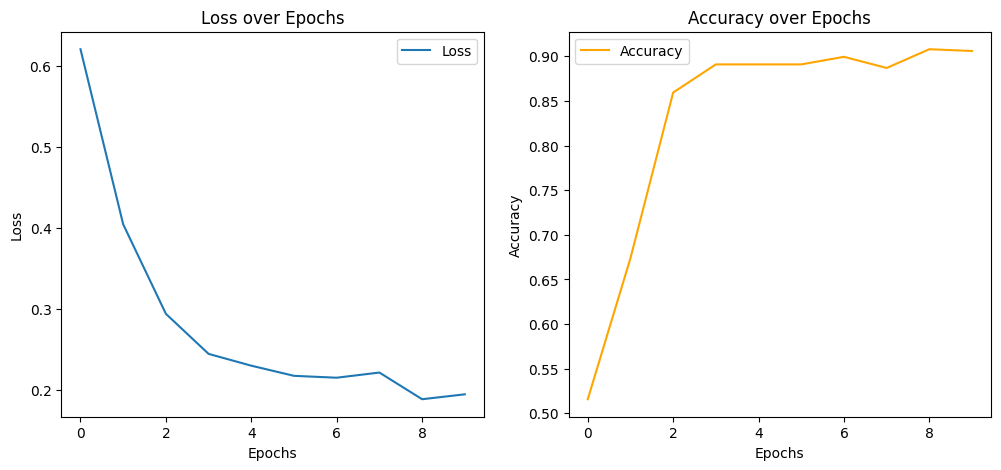

In [24]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### The evaluation of model

In [48]:
quantum_model.eval()
all_preds = []
all_targets = []
all_probs = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = quantum_model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(y_batch.numpy())

        if outputs.shape[1] > 1:
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            all_probs.extend(probs)

y_pred = np.array(all_preds)
y_test_labels = np.array(all_targets)

print(f"Accuracy: {metrics.accuracy_score(y_test_labels, y_pred) * 100:.2f}%")
print("Classification Report:")
print(metrics.classification_report(y_test_labels, y_pred, target_names=["NORMAL", "PNEUMONIA"]))
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test_labels, y_pred)
print(confusion_matrix)

if all_probs:
    print(f"ROC AUC Score: {metrics.roc_auc_score(y_test_labels, all_probs):.4f}")

Accuracy: 83.97%
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.67      0.75      0.71       128
   PNEUMONIA       0.91      0.87      0.89       371

    accuracy                           0.84       499
   macro avg       0.79      0.81      0.80       499
weighted avg       0.85      0.84      0.84       499

Confusion Matrix:
[[ 96  32]
 [ 48 323]]
ROC AUC Score: 0.9048


#### Predicted probability for Positive Class

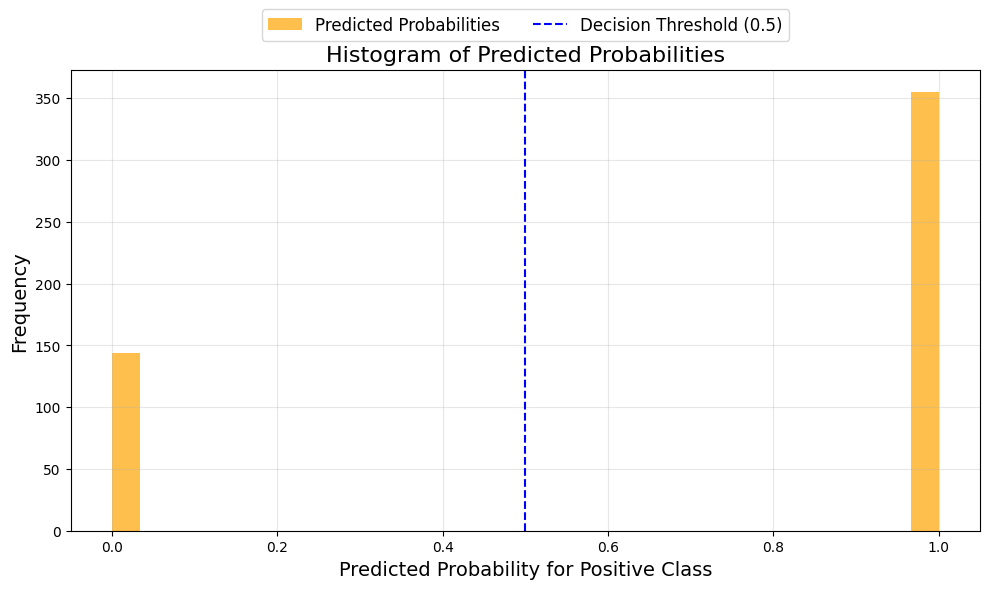

In [40]:
y_pred_probabilities_tensor = torch.tensor(y_pred, dtype=torch.float32)

y_pred_positive_probs = y_pred_probabilities_tensor

predictions = torch.round(y_pred_positive_probs)

plt.figure(figsize=(10, 6))

plt.hist(
    y_pred_positive_probs.numpy(),
    bins=30,
    alpha=0.7,
    color='orange',
    label='Predicted Probabilities'
)

plt.axvline(0.5, color='blue', linestyle='--', label='Decision Threshold (0.5)', linewidth=1.5)

plt.title('Histogram of Predicted Probabilities', fontsize=16)
plt.xlabel('Predicted Probability for Positive Class', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### PCA of model prediction

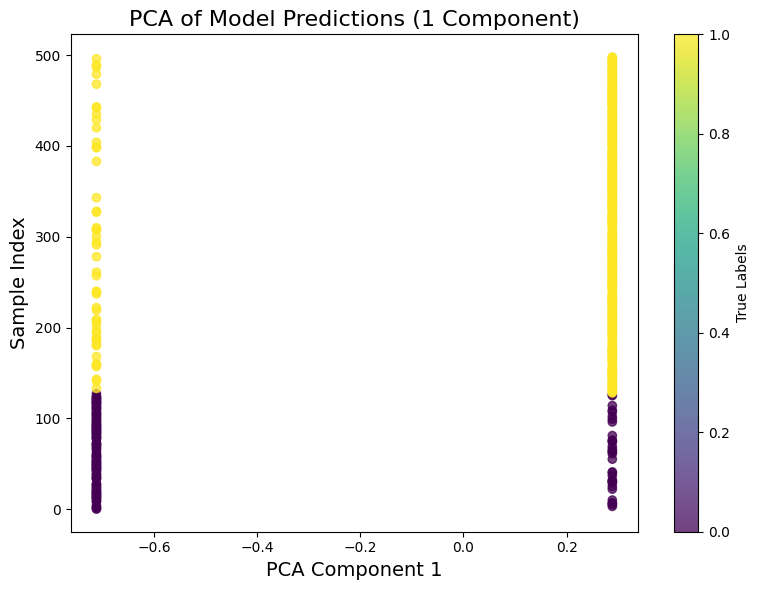

In [41]:
if y_test.ndim > 1:
    y_test_labels = torch.argmax(torch.tensor(y_test), dim=1).numpy()
else:
    y_test_labels = torch.tensor(y_test).numpy()

labels_test_reshaped = y_pred.reshape(-1, 1)
pca = PCA(n_components=1)
features_pca = pca.fit_transform(labels_test_reshaped)

plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], range(len(features_pca)), c=y_test_labels, cmap='viridis', alpha=0.75)

plt.colorbar(label='True Labels')
plt.title('PCA of Model Predictions (1 Component)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('Sample Index', fontsize=14)

plt.tight_layout()
plt.show()

#### Plot the confusion matrix

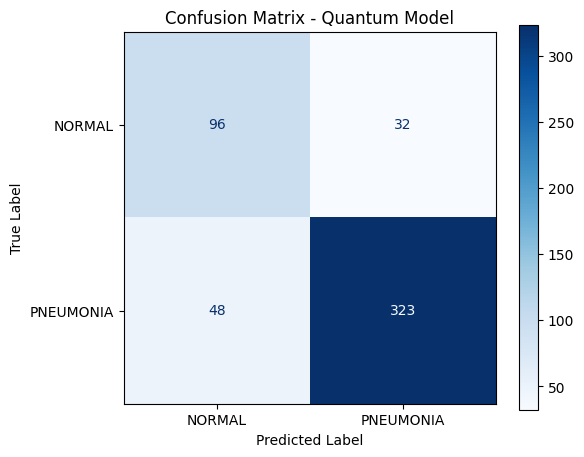

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=True)
ax.set_xticklabels(["NORMAL", "PNEUMONIA"])
ax.set_yticklabels(["NORMAL", "PNEUMONIA"])
plt.title("Confusion Matrix - Quantum Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.show()